In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

# Loading all the transferdata into a dictionary of the top 5 leagues.

In [131]:
WORK_DIR = os.getcwd()
data_folder = os.path.join(WORK_DIR, "data_euro")

# Big five leagues to sort transferdata from
leagues = ['english_premier_league', 'french_ligue_1', 'italian_serie_a', 'spanish_primera_division', 'german_bundesliga_1']

transfer_df = pd.DataFrame()

# Perhaps create a function for this procedure to avoid cluttering

for folder in tqdm(os.listdir(data_folder)):
    temp_path = os.path.join(data_folder, folder)
    
    for league in leagues:
        file_path = os.path.join(temp_path, (league+str('.csv')))
        
        temp_df = pd.read_csv(file_path)

        # Removing nans and 0s in transfer-fees
        temp_df = temp_df[temp_df['fee_cleaned'].notna()]
        temp_df = temp_df[temp_df['fee_cleaned']>0]

        league_column = pd.DataFrame({'league' : [league for i in range(len(transfer_df))]})
        transfer_df = pd.concat([transfer_df, temp_df])


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.33it/s]


# Cleaning the data



In [4]:
# Resetting index
transfer_df = transfer_df.reset_index().drop(columns='index')

# Removing duplicates
transfer_df = transfer_df[~transfer_df.duplicated()]
transfer_df.head()

# Remaking transfer_period (summer/winter) into month (januray/august), denoted by 01/09.
transfer_df.insert(10, "Month", [1 for row in range(len(transfer_df))])
summer_mask = transfer_df["transfer_period"] == "Summer"
transfer_df.loc[summer_mask, "Month"] = 8 # Use this instead of chained indexing 

# Removing the season column
transfer_df = transfer_df.drop(columns = ["transfer_period", "season"])
transfer_df.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,Month,year
0,Middlesbrough FC,Tommy Wright,26.0,Left Winger,Leicester,€910Th.,in,0.91,Premier League,8,1992
1,Middlesbrough FC,Jonathan Gittens,28.0,defence,Southampton,€250Th.,in,0.25,Premier League,8,1992
2,Middlesbrough FC,Stuart Ripley,24.0,Right Winger,Blackburn,€2.00m,out,2.00,Premier League,8,1992
3,Norwich City,Mark Robins,22.0,Centre-Forward,Man Utd,€1.00m,in,1.00,Premier League,8,1992
4,Norwich City,Tim Sherwood,23.0,Central Midfield,Blackburn,€750Th.,out,0.75,Premier League,8,1992


# Adjusting for inflation

In [5]:
# Inflation data from https://www.inflationtool.com/euro/1992-to-present-value?amount=1&year2=2022&frequency=yearly
CPI = pd.read_csv("euro_inflation.csv", sep=";")

# Calculating inverted change in inflation
CPI["Change"] = CPI.loc[len(CPI)-1, "Value"]/CPI["Value"]

# Dropping column and setting index
CPI = CPI.drop(columns=['Value'])
CPI = CPI.set_index("Period")

# Creating dictionary 
inflation = CPI.to_dict()["Change"]

In [6]:
# Creating inflation adjusted fees
df = transfer_df
df.insert(8,"fee_infladj", np.zeros(len(df)))

# Add ignore error here

for year in range(1991,2022):
    year_mask = df["year"] == year
    df["fee_infladj"].loc[year_mask] = inflation[year]*df["fee_cleaned"].loc[year_mask]

C:\Users\hakon\.conda\envs\datascience\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\hakon\.conda\envs\datascience\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\hakon\.conda\envs\datascience\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

## Median market growth

In [7]:
df = df[df["transfer_movement"]== "in"]

Text(0.5, 1.0, 'Inflation adjusted transfer fees \nBig Five Leagues')

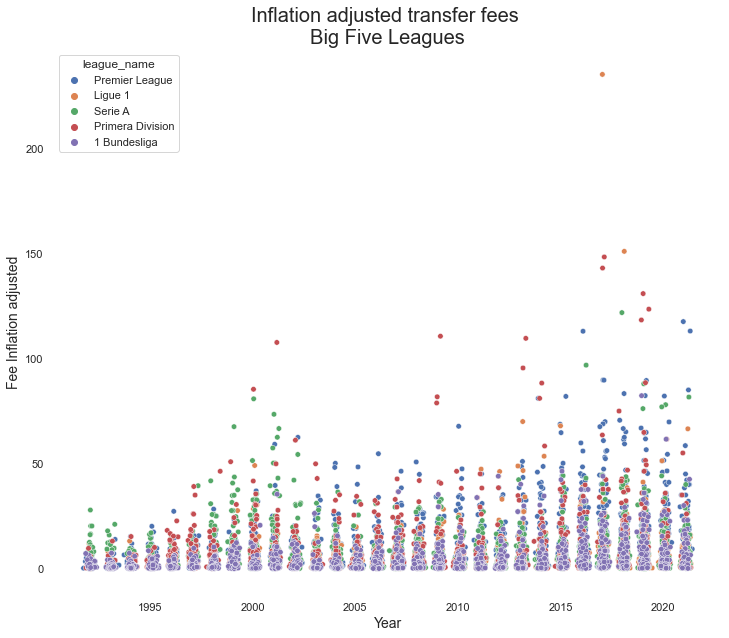

In [8]:
def jitter(values, j):
    return values + np.random.normal(j, 0.1,values.shape)

sns.set(rc={'figure.figsize':(12,10)})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

plot1 = sns.scatterplot(
    x = jitter(df.year, 0.1),
    y = df.fee_infladj,
    hue =df.league_name, s=30, alpha=1 )
plot1.set_xlabel("Year", fontsize = 14)
plot1.set_ylabel("Fee Inflation adjusted", fontsize = 14)
plot1.set_title("Inflation adjusted transfer fees \nBig Five Leagues", fontsize=20)

League: Premier League
Score= 0.7210944319967616 
Regression equation : 
Median = 0.29040116214908407x+-577.5135999237424 

League: Ligue 1
Score= 0.054133599938793964 
Regression equation : 
Median = -0.03411245612600207x+71.2247793374566 

League: Serie A
Score= 0.4938722942086007 
Regression equation : 
Median = -0.18890039797773142x+382.68815587254613 

League: Primera Division
Score= 0.0018576712728669564 
Regression equation : 
Median = 0.00532133393072665x+-7.768806025827516 

League: 1 Bundesliga
Score= 0.4793944790861544 
Regression equation : 
Median = 0.09189216490182836x+-182.77768030422504 



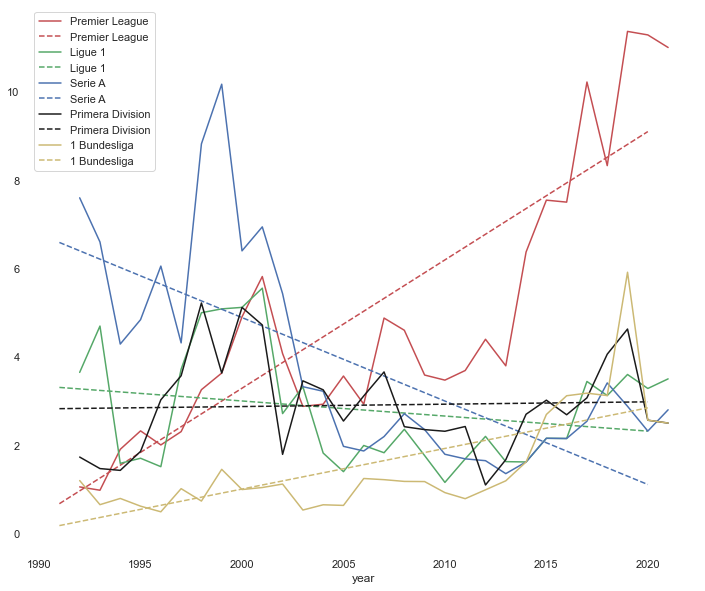

In [76]:
# Median Growth For Each League
median_growth = df.groupby(['league_name', 'year'])['fee_infladj'].median()

from sklearn.linear_model import LinearRegression

league_growth = {}
X = np.arange(1991,2021).reshape(-1,1)

colors = ['r','g','b','k','y']

for i,league in enumerate(df["league_name"].unique()):
    
    # regression of median transfer value vs year
    y = median_growth[league].to_numpy()
    league_growth[league] = LinearRegression().fit(X,y)
    
    # Plotting the median trends
    median_growth[league].plot(label=league,color=colors[i])
    plt.plot(X, league_growth[league].predict(X), linestyle='--', label=league, color=colors[i])
    plt.legend()
    
    # Printing R2 score and regression coefficients for each league
    print("League: " +league + "")
    print("Score= {} ".format(league_growth[league].score(X,y)))
    print("Regression equation : \nMedian = {}x+{} \n".format(league_growth[league].coef_[0],
                                                            league_growth[league].intercept_))

## How is the median correlated with amount of transfers for each season?

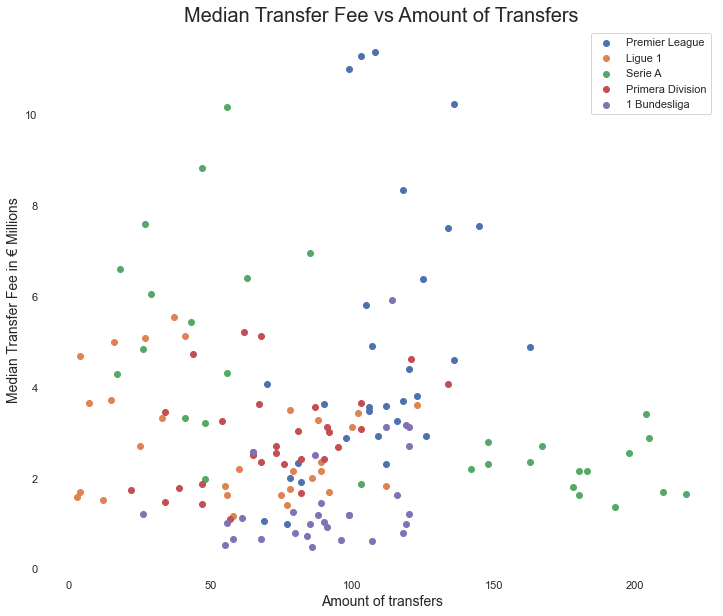

In [47]:
n_transfers = df.groupby(['league_name', 'year'])['fee_infladj'].count()
for league in df["league_name"].unique():
    plt.scatter(n_transfers[league], median_growth[league], label=league)
    plt.xlabel("Amount of transfers", fontsize = 14)
    plt.ylabel("Median Transfer Fee in € Millions", fontsize = 14)
    plt.title("Median Transfer Fee vs Amount of Transfers", fontsize=20)
    plt.legend()

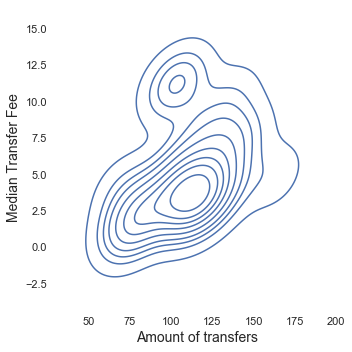

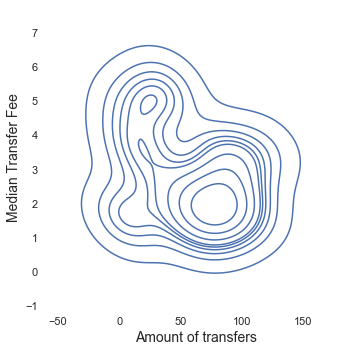

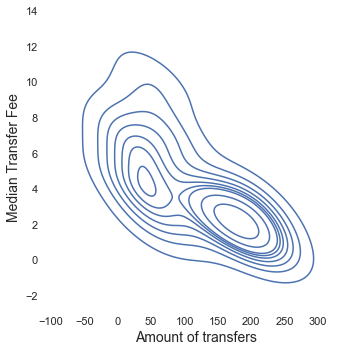

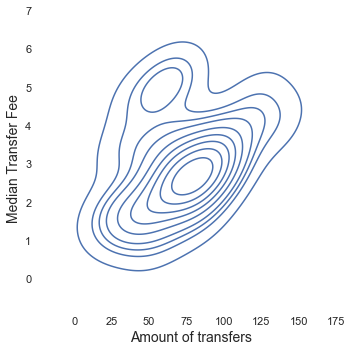

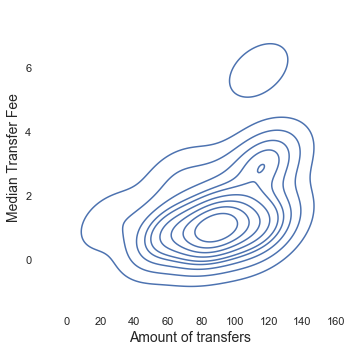

In [75]:
for league in df["league_name"].unique():
    p = sns.displot(x = n_transfers[league], 
                y = median_growth[league],
                kind="kde")
    p.set_axis_labels("Amount of transfers", "Median Transfer Fee", fontsize=14)
    p.set_titles(str(league))

## Distribution plot of inflation adjusted transfers

<AxesSubplot:xlabel='year'>

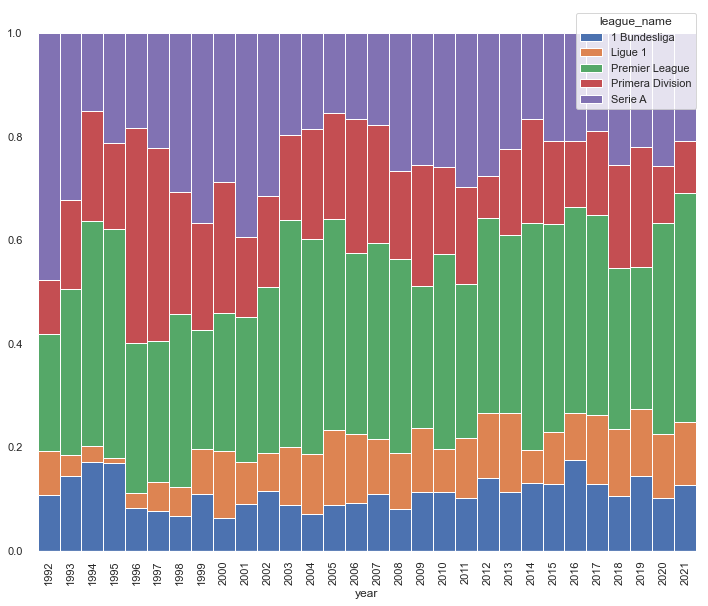

In [129]:
# Cross tab for transfer fees
cross_tab_prop = pd.crosstab(index=df["year"],
                            columns = df["league_name"],
                             values = df["fee_infladj"], aggfunc = 'sum', normalize='index')
cross_tab_prop.plot(kind="bar", stacked=True, width=1)

### Average time between transfers (not change of club as contracts can expire)


In [ ]:
# Only evaluating purchases, not sales
transfers_in = df[df["transfer_movement"] == "in"]

# Creating date time for dataset



In [ ]:

# Finding duplicates of player names
duplicates = transfers_in[transfers_in.duplicated(subset="player_name")]
duplicates.groupby("player_name").describe()

In [ ]:
transfers_in[transfers_in["player_name"] == "Matthias Sammer"]

In [ ]:
grouped_df = df.groupby(["player_name", "year"])["club_name"]   
grouped_df.describe()

In [ ]:
# Weighted skills columns over last 5 seasons?
# Pseudoalg:
#  1 - find playername in skills dataframe
#  2 - add up their 5 last seasons stats
#  3 - Add the weighted skills to the "transfer_df" dataframe
# Then create a rough model to see how well the stats fit.
# NB: How long did they have left on the contract when they were bought? 
# Check distribution of how long people are in a club before they move!

## Analysis methodology
### The idea for the analysis is to create a model, or equation if you will, from an intuitive stand point to estimate expected transfer fee for a player. 
### The transfer fee will be denoted in 2021 inflation adjusted Britsh Pound Sterling £, and also adjusted for the current median market price for 2021. 
### The intuitive equation for the expected transfer fee looks like
$$ \mathbb{E} [TF] = S(T-t)C\cdot e^{-Y *\tau} $$
###  Where $TF$ is the transfer fee, $S$ is the skill level, $(T-t)$ is the contract length of contract at assumed transfer, $C$ is the contract value and $e^{-Y*\tau}$ denotes the "age decay". 


## Skill level
### The skill level is a set of measurable, on pitch football statistics such as Shot-Creating Actions, Goal-Creating Actions, Tackles-Won, Successulf Pressures, Interceptions. Each position will have its own model and weights.
### There are two ways of portraying this information as a 1-D vector: either show the average of some 5 seasons, or just show the best season before that transfer.

### To "squash" all the seasons worth of data into one, a weighted sum is used. To infer how much these weights should be, one would need to evaluate the probability/likelihood of a good season n years in past have of replicating itself in the future. If say Hazard who had a really good season 2018/2019 and subsequently a bad season 2019/2020, how likely is it now he will replicate an equally good season next year? 
### Think about this: A player who had a two very good seasons, followed by a very poor one. How likely is it if a club purchased him, that the next season he would have very good metrics? The last season, which weighs the most, will not portray alot about his skill level, but his previous seasons does.

## Contract length

### The contract length, denoted as $(T-t)$, is the time left of at the time of transfer. $T$ how long the contract is from signing, and small $t$ is how much time has passed since the contract was signed. 
### However, getting accurate data for contract length would seem difficult. Could there be a 

## Contract value
### Coupled in with contract length, is the value of the contract. However, how would the wages affect the transfer fee? Gut feel teels me this should not weigh on the fee of the transfer.

## Age Decay

### 

